# ``VAE2d`` Demo

To use this demo, create the conda env defined in ``requirements-dev.conda.yaml``. To demonstrate ``torch_tools.VAE2d``, we use it to encode and decode MNIST images.

In [1]:
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, RandomRotation
from torchvision.transforms import ColorJitter
from torch.utils.data import DataLoader

batch_size = 100


training_tfms = Compose(
    [
        ToTensor(),
        RandomRotation(180),
        ColorJitter(brightness=0.3),
    ]
)
valid_tfms = Compose([ToTensor()])


train_set = MNIST(
    root="/home/jim/storage/mnist/",
    train=True,
    download=True,
    transform=training_tfms,
)

print(f"There are {len(train_set)} training items.")
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)

print(f"The image size is '{train_set[0][0].shape}'")

There are 60000 training items.
The image size is 'torch.Size([1, 28, 28])'


In this demo, we want bother with a validation loop during training, and will just use the validation set to do some inference at the end. Let's instantiate the model.

In [2]:
from torch.cuda import is_available
from torch import manual_seed

from torch_tools import VAE2d

manual_seed(123)


DEVICE = "cuda" if is_available() else "cpu"

model = VAE2d(
    in_chans=1,
    out_chans=1,
    start_features=16,
    input_dims=(28, 28),
    num_layers=3,
    max_down_feats=64,
    min_up_feats=3,
).to(DEVICE)

print(f"Device set to {DEVICE}")

print(model)

Device set to cuda
VAE2d(
  (encoder): Encoder2d(
    (0): DoubleConvBlock(
      (0): ConvBlock(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
      (1): ConvBlock(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
      )
    )
    (1): DownBlock(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConvBlock(
        (0): ConvBlock(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.1)
        )
        (1): ConvBlock(
          (0): C

Now, we set up the optimiser and loss function.

In [3]:
from torch.optim import Adam
from torch.nn import L1Loss

optimiser = Adam(model.parameters(), lr=1e-4)

loss_func = L1Loss()

And now we write our training loop.

In [4]:
from torch.nn import Module


def train_one_epoch(
    model: Module,
    data_loader: DataLoader,
    optimiser: Adam,
    loss_func: L1Loss,
) -> float:
    """Train ``model`` for a single epoch.

    Parameters
    ----------
    model : Module
        AutoEncoder model.
    data_loader : DataLoader
        Training data loader.
    optimiser : Adam
        Adam optimiser.
    loss_func : L1Loss
        The L1 loss function.

    Parameters
    ----------
    float
        Mean loss per item.

    """
    model.train()
    metrics = {"l1_loss" : 0.0, "kl_loss" : 0.0}
    for batch, _ in data_loader:
        optimiser.zero_grad()

        batch = batch.to(DEVICE)

        preds, kl_div = model(batch)

        l1_loss = loss_func(preds.tanh(), batch)

        (l1_loss + kl_div).backward()

        optimiser.step()

        metrics["l1_loss"] += l1_loss.item()
        metrics["kl_loss"] += kl_div.item()

    return {key : val / len(data_loader) for key, val in metrics.items()}

Now we can train the model.

In [5]:
from time import perf_counter

epochs = 25

metrics = []

for epoch in range(epochs):
    start = perf_counter()

    metrics.append(
        train_one_epoch(
            model,
            train_loader,
            optimiser,
            loss_func,
        )
    )

    stop = perf_counter()

    print(f"{epoch + 1} Epoch time : {stop - start:.6f}")

1 Epoch time : 14.937888
2 Epoch time : 14.397876
3 Epoch time : 14.397785
4 Epoch time : 14.395454
5 Epoch time : 14.456115
6 Epoch time : 14.387329
7 Epoch time : 14.396820
8 Epoch time : 14.319127
9 Epoch time : 14.347398
10 Epoch time : 14.421314
11 Epoch time : 14.518203
12 Epoch time : 14.422738
13 Epoch time : 14.374237
14 Epoch time : 14.426635
15 Epoch time : 14.319905
16 Epoch time : 14.360895
17 Epoch time : 14.387439
18 Epoch time : 14.510429
19 Epoch time : 14.416342
20 Epoch time : 14.381370
21 Epoch time : 14.373733
22 Epoch time : 14.484675
23 Epoch time : 14.353396
24 Epoch time : 14.402891
25 Epoch time : 14.417613


     l1_loss   kl_loss
0   0.078433  0.011862
1   0.042738  0.005780
2   0.037389  0.004942
3   0.034538  0.004285
4   0.032841  0.003743
5   0.031617  0.003192
6   0.030502  0.002613
7   0.029611  0.002173
8   0.028815  0.001901
9   0.028340  0.001734
10  0.027808  0.001598
11  0.027156  0.001491
12  0.026699  0.001410
13  0.026209  0.001348
14  0.025812  0.001297
15  0.025452  0.001234
16  0.025238  0.001238
17  0.024978  0.001187
18  0.024582  0.001150
19  0.024287  0.001115
20  0.024096  0.001100
21  0.023729  0.001064
22  0.023730  0.001072
23  0.023367  0.001047
24  0.023184  0.001015


Text(0, 0.5, 'Loss')

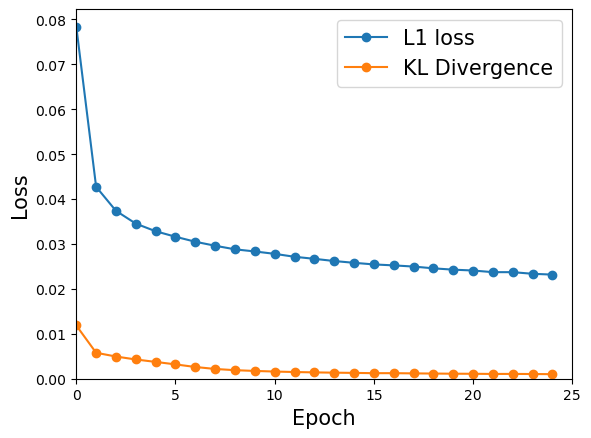

In [6]:
import matplotlib.pyplot as plt
from pandas import DataFrame

metrics = DataFrame(metrics)

print(metrics)

figure, axes = plt.subplots(1, 1)
axes.plot(metrics["l1_loss"], "-o", label="L1 loss")
axes.plot(metrics["kl_loss"], "-o", label="KL Divergence")

axes.set_ylim(bottom=0.0)
axes.set_xlim(left=0.0, right=epochs)

axes.legend(fontsize=15)

axes.set_xlabel("Epoch", fontsize=15)
axes.set_ylabel("Loss", fontsize=15)



In [7]:
for batch, target in train_loader:
    break

Now we can take a look at some predictions from the validation loader.


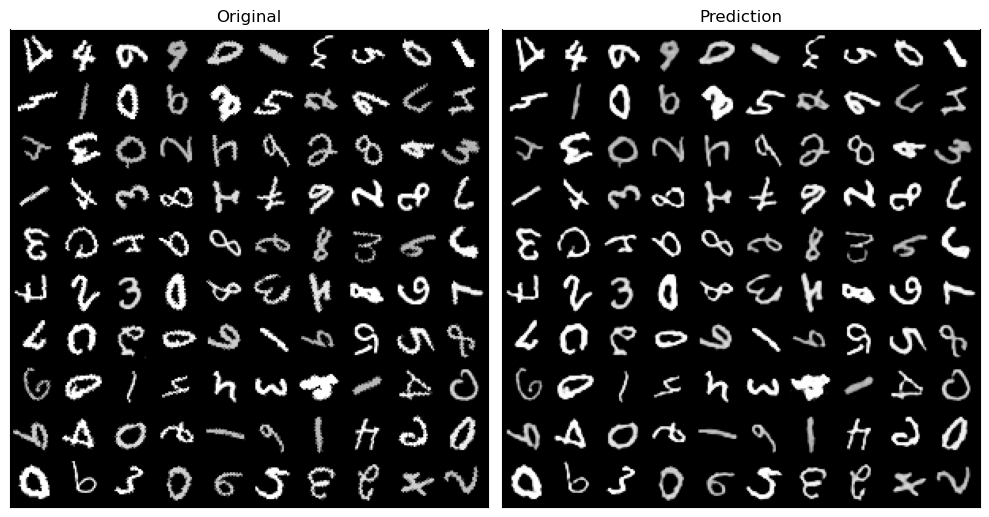

In [8]:
from torch import no_grad
from torchvision.utils import make_grid

with no_grad():
    model.eval()
    preds = model(batch.to(DEVICE)).tanh().detach()



batch_grid = make_grid(batch.cpu(), nrow=10).permute(1, 2, 0)
pred_grid = make_grid(preds.detach().cpu(), nrow=10).permute(1, 2, 0)


pred_grid = pred_grid.clip(0.0, 1.0)


figure, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(batch_grid)
axes[1].imshow(pred_grid)

for axis in axes.ravel():
    axis.set_xticks([])
    axis.set_yticks([])

axes[0].set_title("Original")
axes[1].set_title("Prediction")

figure.tight_layout(h_pad=0.05)